<h1> OCR Software </h1>
<p>I attempted to create a simple optical character recognition software capable of extracting text from images by using PyTorch and OpenCV. The pipeline used is very simple: pre-process image, conduct character segmentation, and feed to trained CONVnet. We use two methods to conduct character segmentation which is histogram projection and contours. Note that by taking the next steps mentioned on my Github, this OCR Software could be heavily improved. For now, it provides a good entry into computer vision.</p>

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models

import helper
import pandas as pd
import numpy as np

from PIL import Image

Below, the trained CONVnet is loaded to be used without CUDA since the computations aren't that large. 

In [56]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.fc1 = nn.Linear(4 * 4 * 128, 256)
    self.fc2 = nn.Linear(256, 47)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu((self.conv1(x))))
    x = self.pool(F.relu((self.conv2(x))))
    x = self.pool(F.relu((self.conv3(x))))

    x = x.view(-1, 4 * 4 * 128)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x

model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=47, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [57]:
model.load_state_dict(torch.load('model_params.pt', map_location=torch.device('cpu')))
mapping = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

To pre-process the image, mutiple functions are defined including: grayscale, shadow removal, noise removal, deskew, and binarization. All of these are applied to the input image to prepare for character segmentation. 

In [58]:
import cv2

def get_grayscale(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image

def remove_shadow(image):
  rgb_planes = cv2.split(image)
  result_planes = []
  result_norm_planes = []
  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)
      result_planes.append(diff_img)
  image = cv2.merge(result_planes)
  return image

def remove_noise(image):
  kernel = np.ones((1, 1), np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)
  image = cv2.erode(image, kernel, iterations=1)
  return image

def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
      angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def binarize(image):
  image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  return image

def processImg(img):
  img = get_grayscale(img)
  img = remove_shadow(img)
  img = remove_noise(img)
  img = deskew(img)
  img = binarize(img)
  img = 255 - img
  return img


Below is an example input involving the alphabet and single-digit numbers. You can test your own inputs by changing the file path to your image path. The image used can be found on my Github.

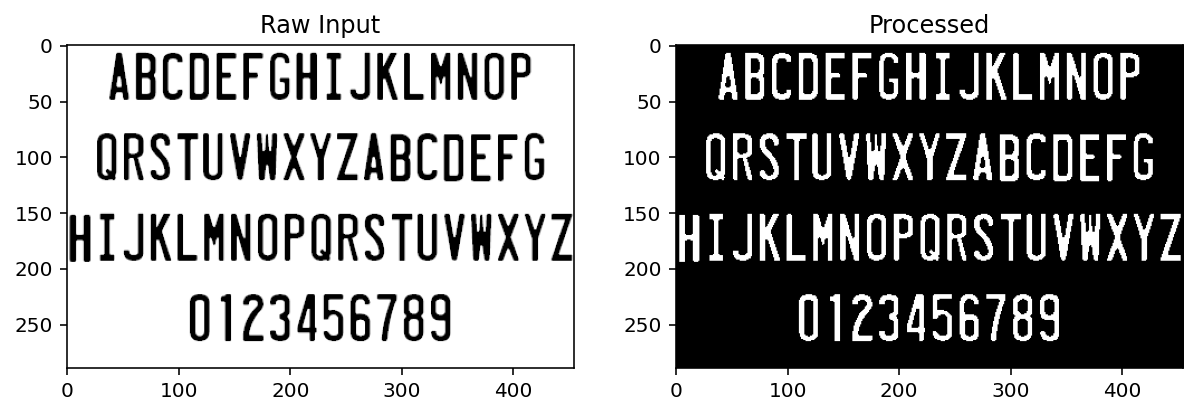

In [59]:
img_dir = "/content/input.png"

img = cv2.imread(img_dir)
rawImg = img
img = processImg(img)

fig = plt.figure(figsize=(10,7))
fig.add_subplot(1, 2, 1)
plt.title("Raw Input")
plt.imshow(rawImg, cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title("Processed")
plt.imshow(img, cmap='gray')

Before character segmentation, we must split the image horizontally into multiple lines to allow for more accurate results. We can do this through a histogram projection method. If we add the sum of all the pixels horizontally and create a chart, we can look for spikes. Note that the dark space are pixels with a value of 0 while white spaces have values close to 1. Hence, by looping through each point in the histogram chart, we can find each horizontal spike and set bounds. 

In [60]:
def split(proj):
  regions = []

  empty = True
  bound1 = 0
  bound2 = 0

  for i in range((len(proj))):
    if proj[i] != 0:
      empty = False
    if not empty and i != 0 and bound1 == 0:
      bound1 = i - 1
    elif not empty and proj[i] == 0:
      bound2 = i
      regions.append((bound1, bound2))
      bound1 = 0
      bound2 = 0
      empty = True
  return regions

<h1> Method 1: </h1>
<p>The same projection method can be used vertically to seperate each character on each line.</p>

In [61]:
hProj = np.sum(img, 1)
hBounds = split(hProj)

hLines = [0]

if len(hBounds) > 1:
  for i in range(len(hBounds) - 1):
      hLines.append((hBounds[i][1] + hBounds[i+1][0]) // 2)

hcropped = []
h, w = img.shape
past = 0
for i in range(1, len(hLines)):
  hcropped.append(img[past:hLines[i], 0:w])
  past = hLines[i]
hcropped.append(img[past:h, 0:w])

markers = []

for line in hcropped:
  vLines = []
  vProj = np.sum(line, 0)
  vBounds = split(vProj)
  for i in range(len(vBounds) - 1):
    vLines.append((vBounds[i][1] + vBounds[i+1][0]) // 2)
  markers.append(vLines)

cropped = []

for i in range(len(markers)):
  past = 0
  temp = []
  for l in range(len(markers[i])):
    temp.append(hcropped[i][0:h, past:markers[i][l]])
    past = markers[i][l]
  temp.append(hcropped[i][0:h, past:w])
  cropped.append(temp)
  print("Number of characters found for line {}: {}".format(i+1, len(temp)))

Number of characters found for line 1: 16
Number of characters found for line 2: 17
Number of characters found for line 3: 19
Number of characters found for line 4: 10


The following function below adds white space around the letter and resizes the image to the required dimensions for the used CONVnet. Then, it feeds the image into the network to produce a prediction for the character.

In [62]:
def predictChar(img):
    test_image = 255 - img
    #_,test_image = cv2.threshold(test,100,255,cv2.THRESH_BINARY)
    test_image = cv2.copyMakeBorder(test_image,10,10,10,10,cv2.BORDER_CONSTANT,value=(255,255,255))
    #test_image = cv2.medianBlur(test_image.copy(),3)
    test_image = cv2.resize(test_image.copy(),(28,28),interpolation = cv2.INTER_AREA)
    t = (255 - test_image.copy())
    convert_tensor = transforms.ToTensor()
    input = convert_tensor(t.astype(np.uint8)).reshape(1, 1, 28, 28)
    input = input * 255
    model.eval()
    with torch.no_grad():
      prob = model(input.float())
      ps = torch.softmax(prob, dim=1)
      top_p, top_class = ps.topk(1, dim=1)
    
    return str(mapping[int(top_class)])

Below is the result for method 1. Clearly, the extracted text has many errors and barely matches the image input. The error here is that the vertical histogram projection method leaves a lot of spaces around each letter. The predictChar function struggles to deal with these spaces and would work better if each character has little empty space. This leads to our next method.

In [63]:
text = []
index = 0

for line in cropped:
  for char in line:
    text.append(predictChar(char))
  text.append("\n")
  index += 1

print("Method 1 results:")
print("".join(text))

Method 1 results:
LBfDEFSnJJKInnOr
ORSTUYMXYZABCOEF5
nIJKLMnORORSTUYMXYZ
VLZ3gSS7eL



<h1> Method 2: </h1>
<p> Here, instead of using vertical histogram projections, we use contours to seperate each character on each line. Note that we still use horizontal histogram projections to split the image horizontally. </p>

In [64]:
def getContours(img, max, min):
  contours, h = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  filtered = []
  sum = 0
  for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      sum += (w*h)

  avg = sum/len(contours)
  for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      if w*h < max and w*h > min:
        filtered.append(cnt)
  
  if len(filtered) == 0:
    return False 
  
  return filtered

def sortContours(contours):
  boundingRects = [cv2.boundingRect(cnt) for cnt in contours]
  sortedCnts, boundingRects = zip(*sorted(zip(contours, boundingRects), key=lambda a: a[1][0]))
  return sortedCnts

Part of the parameters to the contours are a max and min area. These dimensions can be fine-tuned to avoid erroneous contours created from the function. As seen below, the results are much better than the previous method. Especially amongst the letters, the predicted text is quite close. Hence, we have created a simple OCR software that is able to extract text from images. 

In [65]:
sortedCnts = []
for line in hcropped:
  contours = getContours(line, 10000, 700)
  if contours:
    sortedCnts.append(sortContours(getContours(line, 10000, 700)))

text = []
index = 0

for line in sortedCnts:
  for char in line:
    x,y,w,h = cv2.boundingRect(char)
    text.append(predictChar(hcropped[index][y:y+h,x:x+w]))
  text.append("\n")
  index += 1

print("Method 2 results:")
result = "".join(text)
print(result)

Method 2 results:
ABCDEFGHJKLnN0P
QRSTUVNXYZABCDEFG
HJKLnN0PQRSTUVNXYZ
D235S78g

